In [2]:
import pandas as pd
%run 'variables.ipynb'

# Analysis

In [3]:
allgames = [pd.read_csv('./Games/allgames%s.csv' % (year)) for year in range(START_YEAR, END_YEAR)]

In [28]:
# what is the home team win % over these 10 regular seasons? 
num_home_wins = sum([game['home_team_win?'].sum() for game in allgames]) 
num_games = sum([game.shape[0] for game in allgames])

home_win_percentage = num_home_wins / num_games 
print('Home Team Win% =', str(home_win_percentage * 100) + '%')

Home Team Win% = 58.960112778837384%


In [5]:
# Explore sample size for each road trip length for different values of n 

complete_data = pd.read_csv('CompleteData/completedata.csv')

print('sample size for different values of n, where n is the length of a road trip')
for i in range(1, 11):
    print('n = %s:' % str(i), complete_data[complete_data['n_game_road_trip'] == i].shape[0])

sample size for different values of n, where n is the length of a road trip
n = 1: 5965
n = 2: 3039
n = 3: 1581
n = 4: 814
n = 5: 372
n = 6: 157
n = 7: 58
n = 8: 25
n = 9: 8
n = 10: 1


In [6]:
# create a dictionary to analyze the data

AWAY_WIN_PERCENTAGE = 1 - home_win_percentage 

data_dict = {
    'sample size': [],
    'nth game of road trip': [],
    'mean travel distance' : [],
    'games won' : [], 
    'expected games won' : [], # if winning is independent of the length of road trip, how many games should be won? 
    'win %' : []
}
for i in range(1, 11): 
    data = complete_data[complete_data['n_game_road_trip'] == i]
    games_won = int(data['win?'].sum()) 
    size = data.shape[0] 
    winpercentage = games_won / size
    mean_traveldist = data['cumulative_distance'].mean()
    data_dict['sample size'].append(size)
    data_dict['win %'].append(winpercentage)
    data_dict['nth game of road trip'].append(i) 
    data_dict['mean travel distance'].append(mean_traveldist)
    data_dict['games won'].append(games_won) 
    data_dict['expected games won'].append(int(size * AWAY_WIN_PERCENTAGE))

wins_vs_roadtrip = pd.DataFrame.from_dict(data_dict) 
    
display(wins_vs_roadtrip) 

,sample size,nth game of road trip,mean travel distance,games won,expected games won,win %
0,5965,1,1298.250293,2461,2448,0.412573
1,3039,2,2666.405067,1231,1247,0.405067
2,1581,3,3947.884250,637,648,0.402910
3,814,4,5218.847666,327,334,0.401720
4,372,5,6243.266129,166,152,0.446237
5,157,6,7337.318471,70,64,0.445860
6,58,7,8445.948276,26,23,0.448276
7,25,8,9589.600000,11,10,0.440000
8,8,9,10707.125000,3,3,0.375000
9,1,10,10115.000000,0,0,0.000000


In [7]:
# is this data significant?

from scipy.stats import chisquare

observed = data_dict['games won'][0:6] 
observed.append(sum(data_dict['games won'][6:])) # combine the smaller sample sizes
expected = data_dict['expected games won'][0:6]
expected.append(sum(data_dict['expected games won'][6:])) # combine the smaller sample sizes

print(observed, expected)
results = chisquare(observed, expected)

print(results) 

# According to this test, probably not 
# However, this was probably not the best test to use 

[2461, 1231, 637, 327, 166, 70, 40] [2448, 1247, 648, 334, 152, 64, 36]
Power_divergenceResult(statistic=2.904181760741431, pvalue=0.8207734226301346)


From the eye test, there seems to be a potentially significant jump in win % when a team is on their 5th or greater game of a road trip. Let's see if that is true using a difference of proportions test, with the two proportions being the wins during the nth game of the road trip for 1 <= n <= 4, and the wins for 5 <= n <= 10. 

Our null hypothesis will be that there is no difference in winning percentage for 1 <= n <= 4 and for 5 <= n <= 10. Our alternative hypothesis is that there is a difference. Through the following test, we will see if we have enough evidence to reject the null hypothesis.

In [23]:
import numpy as np 

def diff_of_proportions_test(y1, n1, y2, n2): 
    p1, p2 = y1 / n1, y2 / n2 
    p0 = (y1 + y2) / (n1 + n2)
    z_obs = (p1 - p2) / np.sqrt((p0 * (1 - p0) * (1/n1 + 1/n2))) 
    return z_obs
    

In [26]:
p1_wins = wins_vs_roadtrip[wins_vs_roadtrip['nth game of road trip'] <= 4]['games won'].sum()
p1_games = wins_vs_roadtrip[wins_vs_roadtrip['nth game of road trip'] <= 4]['sample size'].sum()

p2_wins = wins_vs_roadtrip[wins_vs_roadtrip['nth game of road trip'] > 4]['games won'].sum()
p2_games = wins_vs_roadtrip[wins_vs_roadtrip['nth game of road trip'] > 4]['sample size'].sum()

z_value = diff_of_proportions_test(p2_wins, p2_games, p1_wins, p1_games)
print('z_value =', z_value)

z_value = 1.7754581981092479


This z-value means that there is greater than a 90% chance that these results are significant and do not represent random chance!  

# Longest Road Trip? Longest Distance Traveled?

We know that the longest road trip was 10 games, and the longest distance traveled was 13039 km. 

But which teams endured these massive road trips? If I was smarter, I would have added a column for "team" and "year" before I mixed up the data, but I didn't, so now we have to write some more code :)

In [27]:
team_longest_dist, team_longest_road_trip = None, None 

for year in range(START_YEAR, END_YEAR):
    for team, city in team_cities.items(): 
        
        file = '%s%s.csv' % (team, year) 
        try:
            team_season = pd.read_csv('TeamTravelDistVsWinning/%s' % file)
        except FileNotFoundError: # not every team, city combination is a valid team 
            continue 
        
        if team_season[team_season['n_game_road_trip'] == 10].shape[0] != 0:
            team_longest_road_trip = (team, year) 
        if team_season[team_season['cumulative_distance'] == 13039].shape[0] != 0: 
            team_longest_dist = (team, year)
            

print('Longest Distance Traveled: %s' % str(team_longest_dist))            
print('Longest Road Trip: %s' % str(team_longest_road_trip))

Longest Distance Traveled: ('PHILADELPHIA 76ERS', 2011)
Longest Road Trip: ('LOS ANGELES CLIPPERS', 2011)


Technically, the Clippers 10 game road trip was actually 11 games! The 11th game was against the Lakers, but I didn't count games between the Clippers and Lakers in my calculations (as I said before, they share a stadium, which defeats the purpose of analyzing the effects of away games). 

# Visualizations

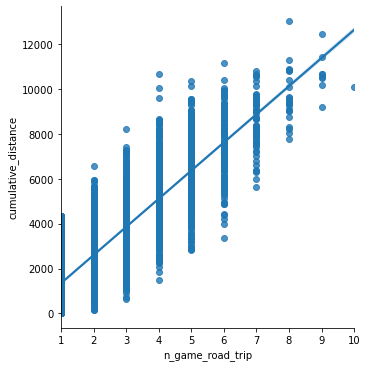

In [30]:
# Visualization of distance traveled vs length of trip 

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.lmplot(x = 'n_game_road_trip', y = 'cumulative_distance', data = complete_data)


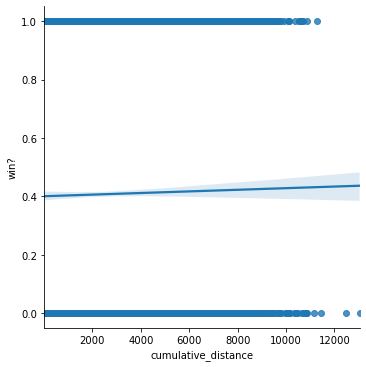

In [31]:
sns.lmplot(x = 'cumulative_distance', y = 'win?', data = complete_data)